In [1]:
!pip install MetPy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import glob
import healpy
import intake
import datetime

import numpy as np
import xarray as xr
import pandas as pd
import uxarray as ux
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import easygems.healpix as egh
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from metpy.units import units
from skimage.measure import regionprops
from scipy.ndimage.measurements import label

/glade/derecho/scratch/priftis/tmp/ipykernel_103713/828904684.py:16: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import label


In [3]:
def get_nn_lon_lat_index(nside, lons, lats):
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        healpy.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

In [4]:
CATALOG = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
LOCATION = "online"
PRODUCT = 'icon_d3hp003'

ZOOM = 11
TIME = "PT1H"
TIME_METHOD = "inst"

ANALYSIS_TIME = (
    np.datetime64("2020-06-01T00:00:00"), np.datetime64("2020-09-01T00:00:00")
)

In [5]:
# Read in simulation data for analysis
cat = intake.open_catalog(CATALOG)[LOCATION]

In [6]:
ds = cat[PRODUCT](zoom=ZOOM).to_dask()

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [7]:
# Subsample simulation data to relevant time frame
ds_dt = ds.sel(time=slice(*ANALYSIS_TIME))

In [8]:
def crop_to_latlon(input, res=3.5):
    # Approximate degree spacing for km resolution
    deg_per_km = 1 / 111.32  # degrees per km
    deg_spacing = res * deg_per_km
    
    latitudes = np.arange(-9, -3 - deg_spacing, deg_spacing)
    longitudes = np.arange(105, 115 + deg_spacing, deg_spacing)
    
    idx = get_nn_lon_lat_index(
        2**ZOOM, longitudes, latitudes
    )
    
    ds_dt_local = input.isel(cell=idx)

    # Add lat/lon coordinates
    ds_dt_local = ds_dt_local.rename({'lon': 'longitude', 'lat': 'latitude'})

    return ds_dt_local

In [9]:
ds_dt_java = crop_to_latlon(ds_dt)

In [10]:
# Mask land
ds_dt_java_ocean = ds_dt_java.where(np.isnan(ds_dt_java.sftlf))

In [11]:
# Calculate wind gradient
def calc_wind_products(input):
    dqu_dx = mpcalc.first_derivative(input.uas, axis='longitude')
    dqu_dy = mpcalc.first_derivative(input.uas, axis='latitude')
    
    dqv_dx = mpcalc.first_derivative(input.vas, axis='longitude')
    dqv_dy = mpcalc.first_derivative(input.vas, axis='latitude')
    
    grad_u = dqu_dx + dqv_dx                                 #gradient in u (s^-1)
    grad_v = dqu_dy + dqv_dy                                 #gradient in v (s^-1)
    divg = dqu_dx + dqv_dy                                   #horizontal divergence (s^-1)
    # vort = dqv_dx - dqu_dy                                   #horizontal vorticity (s^-1)
    # ow_asc = ((vort)**2) - ((dqu_dx - dqv_dy)**2) - ((dqv_dx+dqu_dy)**2)      #Okubo-Weiss Parameter (s^-2)
    
    wgrad = np.sqrt(grad_u**2+grad_v**2)                     #Magnitude of horizontal wind gradient (s^-1)
    return divg, wgrad

In [12]:
divg, wgrad = calc_wind_products(ds_dt_java_ocean)

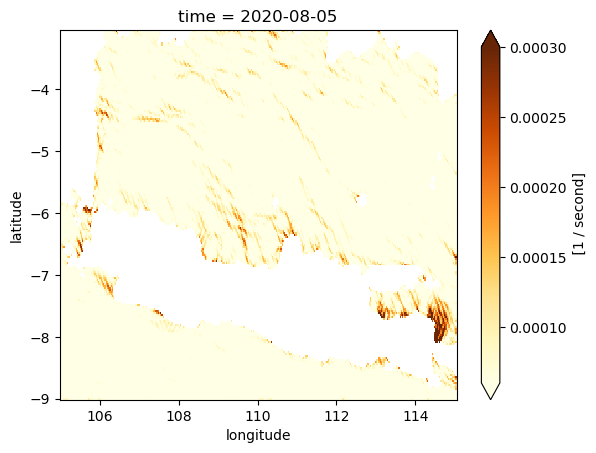

In [29]:
wgrad.isel(time=65).plot(cmap='YlOrBr', vmin=6e-5, vmax=3e-4)

In [ ]:
# Create the figure and Cartopy axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines, borders, etc.
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=0)

# Plot using pcolormesh to avoid Rectangle.set() error
pcm = wgrad.isel(time=61).plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='YlOrBr',
    vmin=6e-5,
    vmax=3e-4,
    cbar_kwargs={'label': 'Wind Gradient (1/s)'}
)

# Optional gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# plt.title('Wind Gradient (time=8)')
plt.savefig('wgrad_20200801.png', dpi=300)
plt.show()

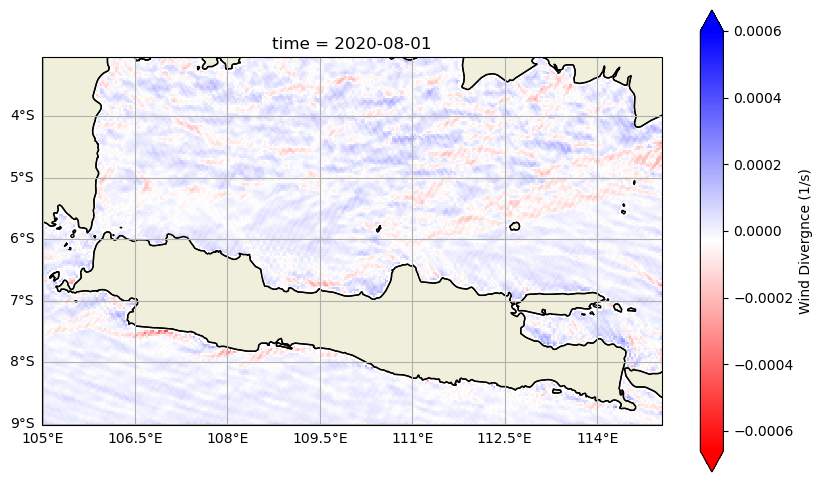

In [39]:
# Create the figure and Cartopy axes
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines, borders, etc.
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=0)

# Plot using pcolormesh to avoid Rectangle.set() error
pcm = divg.isel(time=61).plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.bwr_r,
    vmin=0.0006,
    vmax=-0.0006,
    cbar_kwargs={'label': 'Wind Divergnce (1/s)'}
)

# Optional gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# plt.title('Vertical Gradient of W (time=8) with Topography Background')
plt.savefig('wdivg_20200801.png', dpi=300)
plt.show()

In [ ]:
### LB Identification ###

In [152]:
def land_breeze_detection(wgrad, longitude, latitude, thres=3e-4):
    thres_wgrad = thres * units('1/s')

    records = []    
    for i, dt in enumerate(wgrad.time.values):
        lb_mask = np.zeros((np.shape(wgrad)[1],np.shape(wgrad)[2]), dtype=int)
        lb_mask[wgrad[i,:] >= thres_wgrad] = 1
        
        lb_id, num_lbs = label(lb_mask)
        regions = regionprops(lb_id, wgrad[i,:])

        for eachgrad in np.arange(0, np.max(lb_id)):
            gpix = float(regions[eachgrad].area)
            if gpix >= 15:
                wcx, wcy = regions[eachgrad].centroid
                record = {
                    'time': np.datetime_as_string(dt, unit='s'),
                    'wcent_lon': float(longitude[int(wcy)]),
                    'wcent_lat': float(latitude[int(wcx)]),
                    # 'lons': [longitude[np.where(lb_id==eachgrad)[1]]],
                    # 'lats': [latitude[np.where(lb_id==eachgrad)[0]]],
                    'num_pix': float(regions[eachgrad].area),
                    'orient': float(np.round(regions[eachgrad].orientation,2)),
                    'majaxis': float(np.round(regions[eachgrad].major_axis_length,2))
                }
                records.append(record)

    data = pd.DataFrame(records)
    return data

In [153]:
lons = ds_dt_java_ocean.longitude.values
lats = ds_dt_java_ocean.latitude.values

In [154]:
data = land_breeze_detection(wgrad, lons, lats, thres=1e-4)

In [155]:
data

,time,wcent_lon,wcent_lat,num_pix,orient,majaxis
0,2020-06-01T00:00:00,114.212181,-8.748473,18.0,-1.55,6.77
1,2020-06-01T00:00:00,113.614804,-8.622709,27.0,1.43,9.65
2,2020-06-01T00:00:00,114.809558,-8.528387,25.0,-1.26,9.16
3,2020-06-01T00:00:00,112.231405,-8.465505,21.0,1.38,8.80
4,2020-06-01T00:00:00,113.080309,-8.434064,32.0,1.32,11.87
...,...,...,...,...,...,...
2814,2020-09-01T00:00:00,110.722242,-6.358965,17.0,-1.45,5.86
2815,2020-09-01T00:00:00,105.691700,-6.044556,29.0,1.53,10.51
2816,2020-09-01T00:00:00,105.377291,-5.730147,22.0,-0.89,10.87
2817,2020-09-01T00:00:00,112.262846,-5.698706,16.0,-1.22,14.07


In [187]:
data['time_pd'] = pd.to_datetime(data['time'])
# Define the range
start_time = '2020-08-05'
# end_time = '2020-08-05 06:00:00'

# Filter the DataFrame
# subset = data[(data['time_pd'] >= start_time) & (data['time_pd'] <= end_time)].reset_index(drop=True)

In [188]:
subset = data[(data['time_pd'] >= start_time)].reset_index(drop=True)

In [189]:
subset

,time,wcent_lon,wcent_lat,num_pix,orient,majaxis,time_pd
0,2020-08-05T00:00:00,114.966762,-8.717032,20.0,-0.43,8.92,2020-08-05
1,2020-08-05T00:00:00,113.111750,-8.402623,27.0,1.49,9.60,2020-08-05
2,2020-08-05T00:00:00,114.620913,-7.710923,313.0,-0.64,25.50,2020-08-05
3,2020-08-05T00:00:00,113.206073,-7.585160,83.0,-1.09,16.77,2020-08-05
4,2020-08-05T00:00:00,113.709127,-7.616601,33.0,1.56,9.90,2020-08-05
...,...,...,...,...,...,...,...
760,2020-09-01T00:00:00,110.722242,-6.358965,17.0,-1.45,5.86,2020-09-01
761,2020-09-01T00:00:00,105.691700,-6.044556,29.0,1.53,10.51,2020-09-01
762,2020-09-01T00:00:00,105.377291,-5.730147,22.0,-0.89,10.87,2020-09-01
763,2020-09-01T00:00:00,112.262846,-5.698706,16.0,-1.22,14.07,2020-09-01


In [199]:
# for i in range(0, wgrad.time.shape[0]):
#     formatted_date = datetime.datetime.strptime(str(wgrad.time.values[i])[:10], "%Y-%m-%d").strftime("%Y%m%d")

#     # Create the figure and Cartopy axes
#     fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
#     # Add coastlines, borders, etc.
#     ax.coastlines()
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.LAND, edgecolor='black', zorder=0)
    
#     # Plot using pcolormesh to avoid Rectangle.set() error
#     pcm = wgrad.isel(time=i).plot.pcolormesh(
#         ax=ax,
#         transform=ccrs.PlateCarree(),
#         cmap='YlOrBr',
#         vmin=6e-5,
#         vmax=3e-4,
#         cbar_kwargs={'label': 'Wind Gradient (1/s)'}
#     )
#     subset = data[(data['time_pd'] == datetime.datetime.strptime(str(wgrad.time.values[i])[:10], "%Y-%m-%d"))].reset_index(drop=True)
#     ax.scatter(subset.wcent_lon, subset.wcent_lat)
    
#     # Optional gridlines
#     gl = ax.gridlines(draw_labels=True)
#     gl.top_labels = False
#     gl.right_labels = False
    
#     # plt.title('Wind Gradient (time=8)')
#     plt.savefig(f'./video_plots/lb_wgrad_{formatted_date}.png', dpi=300, bbox_inches='tight')
#     # plt.show()

In [160]:
### Tobac ICON tracks

In [165]:
import glob

mcs_track_files = glob.glob('./icon_tobac_mcs_tracks_july/*nc')
mcs_tracks = xr.open_dataset(mcs_track_files[0])

/glade/derecho/scratch/priftis/tmp/ipykernel_103713/3887251616.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  mcs_tracks = xr.open_dataset(mcs_track_files[0])


In [193]:
subset = data[(data['time_pd'] >= datetime.datetime.strptime(str(wgrad.time.values[i])[:10], "%Y-%m-%d"))].reset_index(drop=True)
subset

,time,wcent_lon,wcent_lat,num_pix,orient,majaxis,time_pd
0,2020-09-01T00:00:00,114.778117,-8.559828,34.0,-1.45,10.50,2020-09-01
1,2020-09-01T00:00:00,113.111750,-8.402623,39.0,1.45,10.43,2020-09-01
2,2020-09-01T00:00:00,114.652354,-7.805246,184.0,-0.91,29.37,2020-09-01
3,2020-09-01T00:00:00,107.515271,-7.679483,20.0,-1.12,8.85,2020-09-01
4,2020-09-01T00:00:00,113.646245,-7.585160,27.0,-0.95,12.36,2020-09-01
5,2020-09-01T00:00:00,106.226195,-7.207869,37.0,-0.59,15.94,2020-09-01
6,2020-09-01T00:00:00,110.470715,-6.579051,66.0,0.96,11.77,2020-09-01
7,2020-09-01T00:00:00,111.099533,-6.484729,19.0,-0.40,13.72,2020-09-01
8,2020-09-01T00:00:00,109.055875,-6.138879,61.0,-0.78,32.13,2020-09-01
9,2020-09-01T00:00:00,110.722242,-6.358965,17.0,-1.45,5.86,2020-09-01
